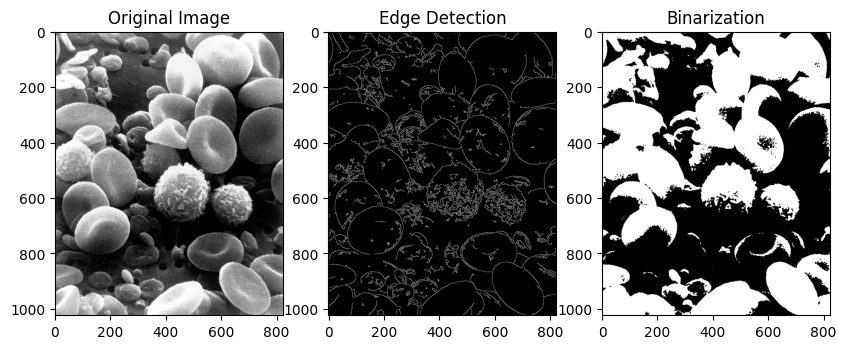

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in gray
image = cv2.imread('SEM_blood_cells.jpg', cv2.IMREAD_GRAYSCALE)

# In SEM images, contrast can be low, making it hard to differentiate between different blood cells. This step helps highlight details by making dark regions lighter and bright regions darker.
image_eq = cv2.equalizeHist(image)

# SEM images often contain noise, which can affect edge detection. Blurring smooths out noise while preserving important structures.
image_blur = cv2.GaussianBlur(image_eq, (5, 5), 0)

# Helps identify blood cell boundaries, making it easier to analyze their shape and structure.
edges = cv2.Canny(image_blur, 50, 150)

# Automatically determines the best threshold to separate objects (blood cells) from the background ((0 = black, 255 = white))
_, binary = cv2.threshold(image_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(131), plt.imshow(image, cmap='gray'), plt.title("Original Image")
plt.subplot(132), plt.imshow(edges, cmap='gray'), plt.title("Edge Detection")
plt.subplot(133), plt.imshow(binary, cmap='gray'), plt.title("Binarization")
plt.show()



The main function of this code is to preprocess and extract features of scanning electron microscope (SEM) blood cell images, including contrast enhancement, denoising, edge detection and binarization.

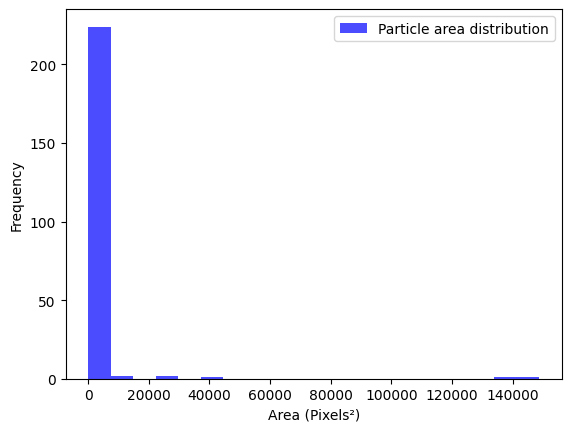

In [2]:
# Calculate connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

# Statistical results
areas = stats[1:, cv2.CC_STAT_AREA]  # Measures the size of each blood cell in pixels²
perimeters = [cv2.arcLength(cv2.findContours((labels == i).astype(np.uint8) * 255, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0], True) 
              for i in range(1, num_labels)] # Measures the boundary length of each cell, which can be used to analyze shape irregularities.

# Helps determine the shape characteristics of blood cells
widths = stats[1:, cv2.CC_STAT_WIDTH]
heights = stats[1:, cv2.CC_STAT_HEIGHT]
aspect_ratios = widths / heights

# Display statistical results
plt.hist(areas, bins=20, color='blue', alpha=0.7, label="Particle area distribution")
plt.xlabel("Area (Pixels²)"), plt.ylabel("Frequency"), plt.legend()
plt.show()


Perform connected component analysis to calculate the area, perimeter, aspect ratio of each cell and 
plot the histogram distribution of particle area

In [3]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PyQt5.QtWidgets import QApplication, QWidget, QPushButton, QLabel, QFileDialog, QVBoxLayout, QScrollArea
from PyQt5.QtGui import QPixmap, QImage
from PyQt5.QtCore import Qt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure

class SEMAnalyzer(QWidget):
    def __init__(self):
        super().__init__()
        self.initUI()

    def initUI(self):
        self.setWindowTitle("PEMFC SEM Analysis")
        self.setGeometry(100, 100, 800, 600)

        self.scrollArea = QScrollArea(self)
        self.label = QLabel()
        self.label.setAlignment(Qt.AlignCenter)
        self.scrollArea.setWidgetResizable(True)
        self.scrollArea.setWidget(self.label)

        self.btn_upload = QPushButton("Upload Image", self)
        self.btn_upload.clicked.connect(self.upload_image)

        self.btn_analyze = QPushButton("Analyze Image", self)
        self.btn_analyze.clicked.connect(self.analyze_image)

        self.figure = Figure()
        self.canvas = FigureCanvas(self.figure)

        layout = QVBoxLayout()
        layout.addWidget(self.scrollArea)
        layout.addWidget(self.btn_upload)
        layout.addWidget(self.btn_analyze)
        layout.addWidget(self.canvas)  # Add the canvas to the layout
        self.setLayout(layout)

    def upload_image(self):
        options = QFileDialog.Options()
        file_path, _ = QFileDialog.getOpenFileName(self, "Select image file", "", "Images (*.png *.jpg *.bmp)", options=options)
        if file_path:
            self.image_path = file_path
            pixmap = QPixmap(file_path)
            self.label.setPixmap(pixmap.scaled(self.label.size(), Qt.KeepAspectRatio))

    def analyze_image(self):
        if hasattr(self, 'image_path'):
            image = cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)
            image_blur = cv2.GaussianBlur(image, (5, 5), 0)
            _, binary = cv2.threshold(image_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
            areas = stats[1:, cv2.CC_STAT_AREA]

            self.figure.clear()  # Clear any previous plot
            ax = self.figure.add_subplot(111)
            ax.hist(areas, bins=20, color='blue', alpha=0.7, label="Particle area distribution")
            ax.set_xlabel("Area (pixels²)")
            ax.set_ylabel("Frequency")
            ax.legend()
            self.canvas.draw()  # Draw the new plot

if __name__ == '__main__':
    app = QApplication(sys.argv)
    ex = SEMAnalyzer()
    ex.show()
    sys.exit(app.exec_())

SystemExit: 0

/Users/yanyanyou/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


With GUI